# Neural machine translation with a Transformer and Keras

This tutorial demonstrates how to create and train a sequence-to-sequence Transformer model to translate Portuguese into English. The Transformer was originally proposed in "Attention is all you need" by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with self-attention. Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the Google AI Blog post:

Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the NMT with attention tutorial. A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers. This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

### Setup

In [1]:
#Uninstall the current CUDA version
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

#Download CUDA 10.0
!wget  --no-clobber https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
#install CUDA kit dpkg
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda-10-0

Streaming output truncated to the last 5000 lines.
Note, selecting 'nvidia-361-updates' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-dev' for glob 'nvidia*'
Note, selecting 'nvidia-opencl-dev' for glob 'nvidia*'
Note, selecting 'nvidia-headless-515-server' for glob 'nvidia*'
Note, selecting 'nvidia-container-toolkit' for glob 'nvidia*'
Note, selecting 'nvidia-cg-dev' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-cg-doc' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-340-updates' for glob 'nvidia*'
Note, selecting 'nvidia-381-updates' for glob 'nvidia*'
Note, selecting 'nvidia-opencl-icd-331' for glob 'nvidia*'
Note, selecting 'nvidia-opencl-icd-340' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-gdb' for glob 'nvidia*'
Note, selecting 'nvidia-legacy-390xx-smi' for glob 'nvidia*'
Note, selecting 'nvidia-experimental-304' for glob 'nvidia*'
Note, selecting 'nvi

In [2]:
!nvidia-smi

Tue Jun 27 09:09:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# We need to downgrade nvidia driver to nvidia-driver-515
# otherwise tf.keras.layers.LayerNormalization will give an error
# https://stackoverflow.com/questions/52551296/keras-batchnormalization-layer-internalerror-cudnn-launch-failure
!sudo apt-get purge '*nvidia*'
!sudo apt install nvidia-driver-515

Streaming output truncated to the last 5000 lines.
Package 'linux-objects-nvidia-418-server-5.15.0-1025-gcp' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1025-intel-iotg' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1025-oracle' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1026-aws' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1026-gcp' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1026-intel-iotg' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1027-aws' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1027-gcp' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1027-intel-iotg' is not installed, so not removed
Package 'linux-objects-nvidia-418-server-5.15.0-1027-oracle' is not installed, so not removed
Package 'lin

In [4]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-compiler-10-0 cuda-cublas-10-0
  cuda-cublas-dev-10-0 cuda-cudart-10-0 cuda-cudart-dev-10-0 cuda-cufft-10-0
  cuda-cufft-dev-10-0 cuda-cuobjdump-10-0 cuda-cupti-10-0 cuda-curand-10-0
  cuda-curand-dev-10-0 cuda-cusolver-10-0 cuda-cusolver-dev-10-0
  cuda-cusparse-10-0 cuda-cusparse-dev-10-0 cuda-documentation-10-0
  cuda-driver-dev-10-0 cuda-gdb-10-0 cuda-gpu-library-advisor-10-0
  cuda-libraries-10-0 cuda-libraries-dev-10-0 cuda-license-10-0
  cuda-memcheck-10-0 cuda-misc-headers-10-0 cuda-npp-10-0 cuda-npp-dev-10-0
  cuda-nsight-10-0 cuda-nsight-compute-10-0 cuda-nvcc-10-0 cuda-nvdisasm-10-0
  cuda-nvgraph-10-0 cuda-nvgraph-dev-10-0 cuda-nvjpeg-10-0
  cuda-nvjpeg-dev-10-0 cuda-nvml-dev-10-0 cuda-nvprof-10-0 cuda-nvprune-10-0
  cuda-nvrtc-10-0 cuda-nvrtc-dev-10-0 cuda-nvtx-10-

In [2]:
!pip install -q -U tensorflow-text tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 24.4 MB/s eta 0:00:00


In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

### Download the dataset


In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDM3ULB/ted_hrlr_translate-trai…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDM3ULB/ted_hrlr_translate-vali…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteDM3ULB/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_examples

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [6]:
# So by taking 3 batches we divide the whole dataset to 3 part
for pt_ex, en_ex in train_examples.batch(3).take(1):
    print(f'Portuguese sentence:\n')
    for text in pt_ex.numpy():
        print(text.decode('utf-8'))
    print(f'\nEnglish sentence: \n')
    for text in en_ex.numpy():
        print(text.decode('utf-8'))

Portuguese sentence:

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

English sentence: 

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a token or token ID (a numeric representation).

This tutorial uses the tokenizers built in the subword tokenizer tutorial. That tutorial optimizes two text.BertTokenizer objects (one for English, one for Portuguese) for this dataset and exports them in a TensorFlow saved_model format.

In [7]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [8]:
tokenizers = tf.saved_model.load(model_name)


In [9]:
# This model contains two tokenizer, one for English one for Portuguese
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The tokenize method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [10]:
encoded = tokenizers.en.tokenize(en_ex)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [11]:
# With the detokenize method we can convert back the tokens to text
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
    print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level lookup method converts from token-IDs to token text:

In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word 'searchability' is decomposed into 'search' and '##ability', and the word 'serendipity' into 's', '##ere', '##nd', '##ip' and '##ity'.

Note that the tokenized text includes '[START]' and '[END]' tokens.


The distribution of tokens per example in the dataset is as follows:

In [13]:
# So we need to measure what is the max length sequence
lengths = []

for pt_examples, en_examples in train_examples.batch(1024): # that is 51 sample sequences (len(train_examples)/1024)
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

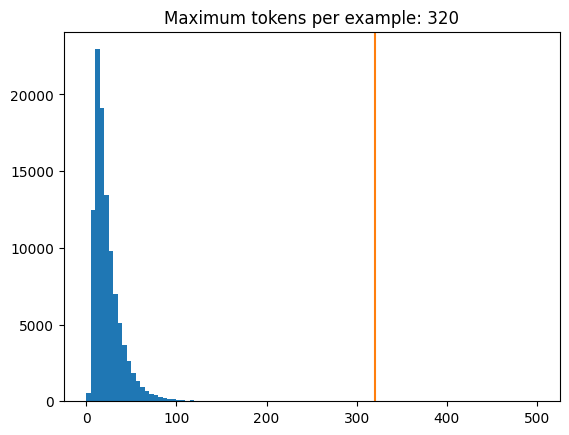

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with tf.data

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than MAX_TOKENS.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the label is the id of the next token.
4. It converts the RaggedTensors to padded dense Tensors.
5. It returns an (inputs, labels) pair.

In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training.

1. It tokenizes the text, and filters out the sequences that are too long. (The batch/unbatch is included because the tokenizer is much more efficient on large batches).
2. The cache method ensures that that work is only executed once.
3. Then shuffle and, dense_to_ragged_batch randomize the order and assemble batches of examples.
4. Finally prefetch runs the dataset in parallel with the model to ensure that data is available when needed. See Better performance with the tf.data for details.

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

### Test the Dataset

In [17]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting tf.data.Dataset objects are setup for training with Keras. Keras Model.fit training expects (inputs, labels) pairs. The inputs are pairs of tokenized Portuguese and English sequences, (pt, en). The labels are the same English sequences shifted by 1. This shift is so that at each location input en sequence, the label in the next token.

In [18]:
# Take one batch to explore
for (pt, en), en_labels in train_batches.take(1):
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 83)
(64, 78)
(64, 78)


The en and en_labels are the same, just shifted by 1:

In [19]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2  110   79   94  298 1566   71 4718   72  125], shape=(10,), dtype=int64)
tf.Tensor([ 110   79   94  298 1566   71 4718   72  125  173], shape=(10,), dtype=int64)


### Define the components of the transformer

#### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a tf.keras.layers.Embedding layer. The Embedding layer alone wouldn't be enough, because there are words in a sentence, that have different meaning in another sentence. With Positional Encoding this can be solved, therefore contextual information can be learned.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

In [20]:
# Positional encoding implementation in Python
# Literally the output is a vector that will provide context information
# based on the position of word in the sentence

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [22]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [23]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 78), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

#### Add and normalize

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a LayerNormalization layer.

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are updated by the attention layers instead of replaced), while the normalization maintains a reasonable scale for the outputs.

#### The base attention layer

Attention is focused on giving a weight matrix based on each word's connection with other words in the sequence, to explore their interactions.

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a layers.MultiHeadAttention, a layers.LayerNormalization and a layers.Add. Each of these use-cases will be implemented as sub-classes.

In [24]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs) # How attention works: https://en.wikipedia.org/wiki/Attention_(machine_learning)
    self.layernorm = tf.keras.layers.LayerNormalization() # To scale output from layer
    self.add = tf.keras.layers.Add() # For the residual connections

#### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder.

In [25]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [26]:
# Lets test CrossAttention layer
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape) # The first batch's samples with positional embs applied
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape) # output shape after CrossAttention

(64, 83, 512)
(64, 78, 512)
(64, 78, 512)


#### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length.

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. (unlike with LSTM for example where sequence elements could be passed one after another)

In [27]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [28]:
# Lets test GlobalSelfAttention layer
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 83, 512)
(64, 83, 512)


#### The causal self attention layer

This layer does a similar job as the global self attention layer (in the encoder), for the output sequence (in the decoder).

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention values.

This is taken care of automatically if you pass use_causal_mask = True to the MultiHeadAttention layer when you call it:

In [29]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [30]:
# Lets test CausalSelfAttention layer

sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 78, 512)
(64, 78, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [31]:
out1 = sample_csa(embed_en(en[:, :3]))
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

#### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder.

The network consists of two linear layers (tf.keras.layers.Dense) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization.

In [32]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [33]:
# Lets test the feed forward network

sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 78, 512)
(64, 78, 512)


#### The encoder layer

The encoder contains a stack of N encoder layers. Where each EncoderLayer contains a GlobalSelfAttention and FeedForward layer.

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [35]:
# Lets test the encoder layer

sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 83, 512)
(64, 83, 512)


#### The encoder

In [36]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [37]:
# Lets test the encoder

# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 83)
(64, 83, 512)


#### The decoder layer

The decoder's stack is slightly more complex, with each DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer.

In [38]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [39]:
# Lets test the decoder layer

sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 78, 512)
(64, 83, 512)
(64, 78, 512)


#### The decoder

In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [41]:
# Lets test the decoder

# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 78)
(64, 83, 512)
(64, 78, 512)


### The Transformer

You now have Encoder and Decoder. To complete the Transformer model, you need to put them together and add a final linear (Dense) layer which converts the resulting vector at each location into output token probabilities.

In [42]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    # Final layer of decoder to retreive the prediction probabilities of all possible word output
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [43]:
# Hyperparams

num_layers = 4      # num of layers
d_model = 128       # input dim for the embeddings
dff = 512           # input dim for the ffw network
num_heads = 8       # num of self-attention head
dropout_rate = 0.1  # 10% dropout

In [78]:
# Initiate the transformer model

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [79]:
# Test it
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 78)
(64, 83)
(64, 78, 7010)


In [80]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 78, 83)


In [81]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  3632768   
                                                                 
 decoder_2 (Decoder)         multiple                  5647104   
                                                                 
 dense_55 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


### Training

#### Setup the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.

In [82]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [83]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

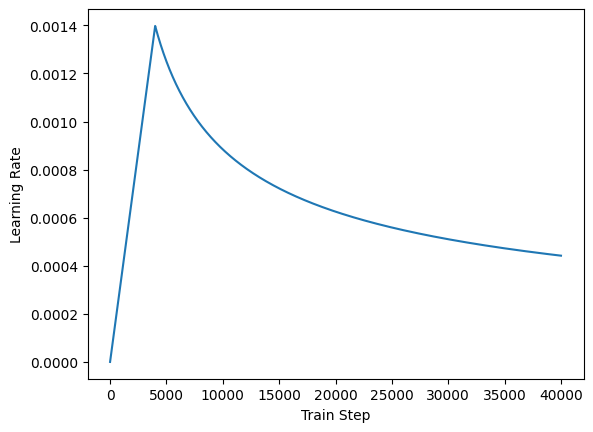

In [84]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

#### Setup the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (tf.keras.losses.SparseCategoricalCrossentropy):

In [85]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Train the model

In [86]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [87]:
# Well it takes 3+ hours on first epoch so I wont be able to
# train it on the freely available T4 GPU...
# (1. the dataset is big 2. the model is too complex and also has 10 mil parameters)

#transformer.fit(train_batches,
#                epochs=20,
#                validation_data=val_batches)

In [88]:
# So what I try to do is taking only X% of the dataset and experiment with it.
# Since the whole dataset is 810*64 sample. 1% = only 8*64 sample

train_batches_partition = train_batches.take(int(len(train_batches)*0.05))
val_batches_partition = val_batches.take(int(len(val_batches)*0.05))

In [89]:
EPOCHS = 50
transformer.fit(train_batches_partition,
                epochs=EPOCHS,
                validation_data=val_batches_partition)

Epoch 1/50
40/40 [==============================] - 51s 425ms/step - loss: 8.8142 - masked_accuracy: 8.8023e-04
Epoch 2/50
40/40 [==============================] - 16s 381ms/step - loss: 8.6212 - masked_accuracy: 0.0415
Epoch 3/50
40/40 [==============================] - 15s 365ms/step - loss: 8.4442 - masked_accuracy: 0.0595
Epoch 4/50
40/40 [==============================] - 12s 300ms/step - loss: 8.2157 - masked_accuracy: 0.0823
Epoch 5/50
40/40 [==============================] - 13s 311ms/step - loss: 7.9251 - masked_accuracy: 0.0925
Epoch 6/50
40/40 [==============================] - 12s 288ms/step - loss: 7.5640 - masked_accuracy: 0.0943
Epoch 7/50
40/40 [==============================] - 12s 292ms/step - loss: 7.1943 - masked_accuracy: 0.0949
Epoch 8/50
40/40 [==============================] - 12s 287ms/step - loss: 6.8432 - masked_accuracy: 0.0981
Epoch 9/50
40/40 [==============================] - 12s 296ms/step - loss: 6.5393 - masked_accuracy: 0.1091
Epoch 10/50
40/40 [=====

In [110]:
transformer.fit(train_batches_partition,
                epochs=30,
                validation_data=val_batches_partition)

Epoch 1/30
40/40 [==============================] - 10s 229ms/step - loss: 3.5255 - masked_accuracy: 0.4109
Epoch 2/30
40/40 [==============================] - 10s 247ms/step - loss: 3.5504 - masked_accuracy: 0.4052
Epoch 3/30
40/40 [==============================] - 11s 255ms/step - loss: 3.5292 - masked_accuracy: 0.4077
Epoch 4/30
40/40 [==============================] - 11s 255ms/step - loss: 3.4654 - masked_accuracy: 0.4152
Epoch 5/30
40/40 [==============================] - 9s 225ms/step - loss: 3.4333 - masked_accuracy: 0.4178
Epoch 6/30
40/40 [==============================] - 9s 225ms/step - loss: 3.4279 - masked_accuracy: 0.4175
Epoch 7/30
40/40 [==============================] - 10s 234ms/step - loss: 3.3790 - masked_accuracy: 0.4218
Epoch 8/30
40/40 [==============================] - 10s 229ms/step - loss: 3.3267 - masked_accuracy: 0.4299
Epoch 9/30
40/40 [==============================] - 9s 223ms/step - loss: 3.2584 - masked_accuracy: 0.4393
Epoch 10/30
40/40 [============

In [111]:
transformer.fit(train_batches_partition,
                epochs=30,
                validation_data=val_batches_partition)

Epoch 1/30
40/40 [==============================] - 10s 251ms/step - loss: 2.6494 - masked_accuracy: 0.5014
Epoch 2/30
40/40 [==============================] - 10s 246ms/step - loss: 2.6254 - masked_accuracy: 0.5097
Epoch 3/30
40/40 [==============================] - 10s 233ms/step - loss: 2.5918 - masked_accuracy: 0.5119
Epoch 4/30
40/40 [==============================] - 9s 222ms/step - loss: 2.5809 - masked_accuracy: 0.5140
Epoch 5/30
40/40 [==============================] - 10s 239ms/step - loss: 2.5305 - masked_accuracy: 0.5173
Epoch 6/30
40/40 [==============================] - 10s 231ms/step - loss: 2.5441 - masked_accuracy: 0.5172
Epoch 7/30
40/40 [==============================] - 10s 236ms/step - loss: 2.5067 - masked_accuracy: 0.5219
Epoch 8/30
40/40 [==============================] - 10s 232ms/step - loss: 2.4815 - masked_accuracy: 0.5243
Epoch 9/30
40/40 [==============================] - 10s 248ms/step - loss: 2.4795 - masked_accuracy: 0.5221
Epoch 10/30
40/40 [==========

### Run inference

You can now test the model by performing a translation. The following steps are used for inference:

- Encode the input sentence using the Portuguese tokenizer (tokenizers.pt). This is the encoder input.
- The decoder input is initialized to the [START] token.
- Calculate the padding masks and the look ahead masks.
- The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
- Concatenate the predicted token to the decoder input and pass it to the decoder.
- In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Define the Translator class by subclassing tf.Module:




In [112]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [113]:
# Create an instance of this Translator class, and try it out a few times:

translator = Translator(tokenizers, transformer)

def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [114]:
# Example 1:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we need to solve .
Ground truth   : this is a problem we have to solve .


In [115]:
# Example 2:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [116]:
# Example 3:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' ll take a lot of sharing a few different stories that will happen .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


### Create attention plots

In [117]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [118]:
# Create a function that plots the attention when a token is generated:

def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [119]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [120]:
# These are the input (Portuguese) tokens:

in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [121]:
# And these are the output (English translation) tokens:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

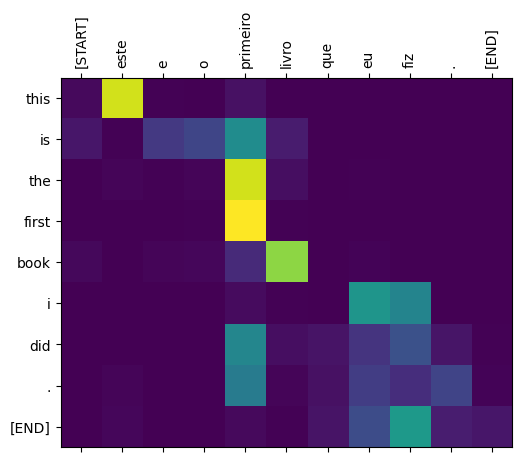

In [122]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [123]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

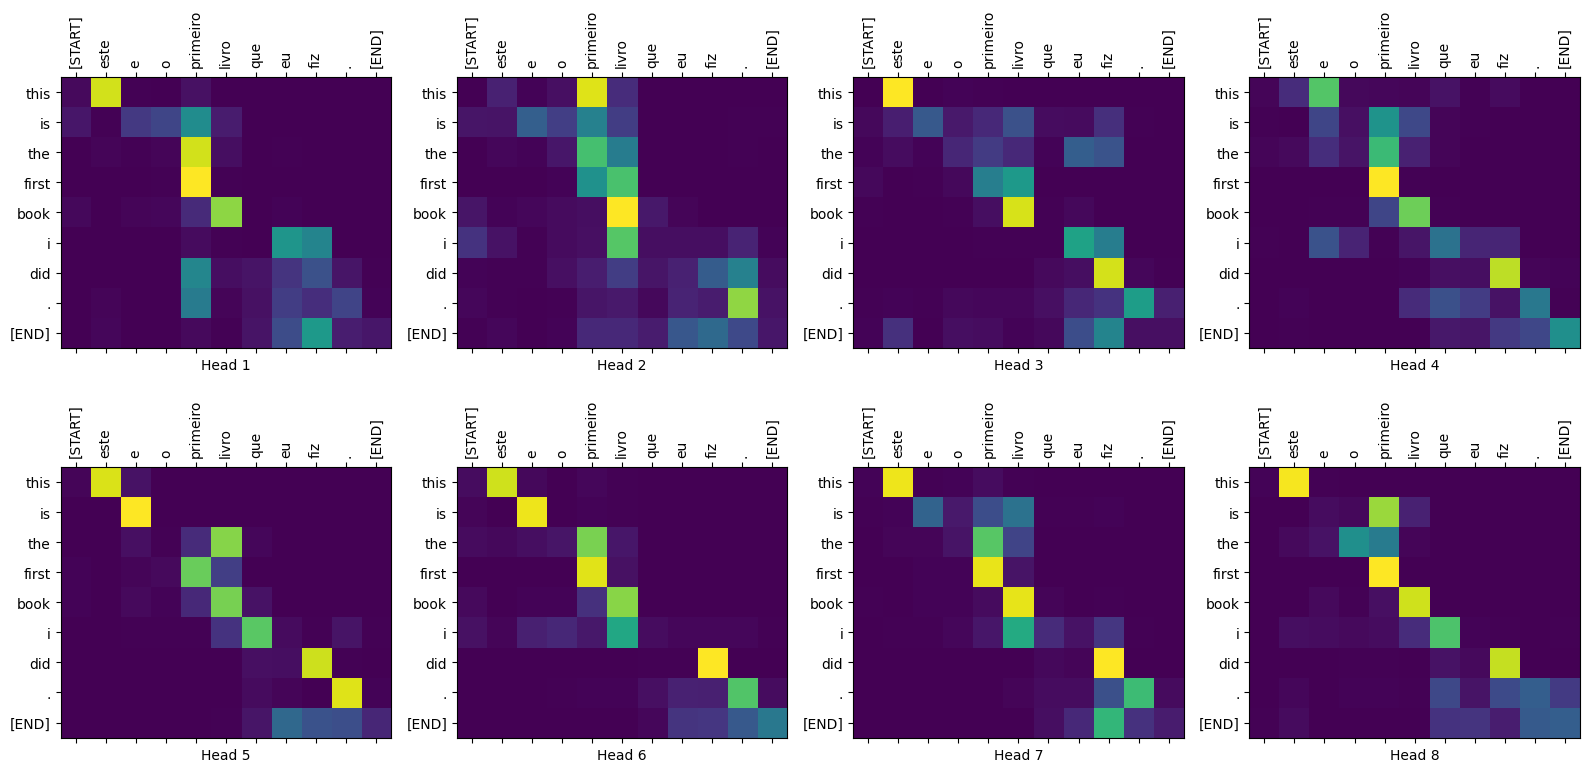

In [124]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i just just just about tribrush in the stamo .
Ground truth   : I read about triceratops in the encyclopedia.


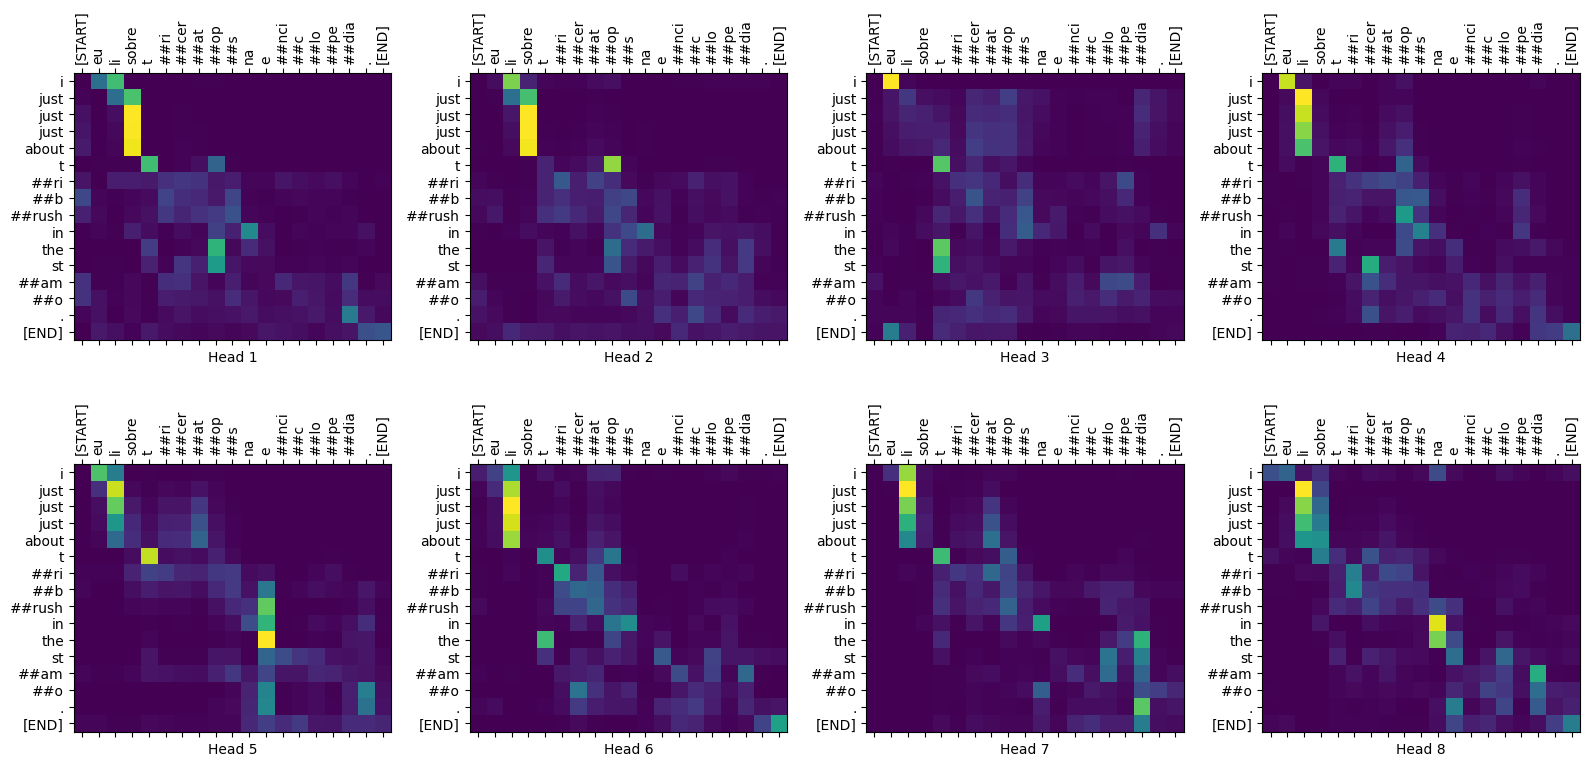

In [125]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

#### Export the model

In [126]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [127]:
translator = ExportTranslator(translator)

In [128]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [129]:
tf.saved_model.save(translator, export_dir='translator')

In [130]:
reloaded = tf.saved_model.load('translator')

In [131]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'